# HW01, Q02

This is the work associated with part of the homework. I already have the dataset in the repository so I will get started immediately with the following.

For the year 2020, construct the following behavioral networks:
1. the 5cm proximity network.
2. The touch network.
3. The mating network.

For each network clean the data in the following way:
- Remove beetles with unkown identities.
- Separate beetles into different condos.

In [1]:
# Necessary imports.
import polars as pl
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
df = pl.read_csv('cook-social-2020.csv') # Load data
df.sample(5) # Just to see if everything looks right.

datetime,condo,focal_id,sex,behavior,grid_cell,cell_location,partner_id,partner_interaction
str,str,str,str,str,str,str,str,str
"""2018-08-01T22:12:00Z""","""1A""","""2PX""","""M""","""CRT""","""B17""","""B""","""3PT""","""Mating Partners"""
"""2018-07-17T23:47:00Z""","""6A""","""3M7""","""F""","""S""","""C18""","""B""","""2H7""","""Touch Partners"""
"""2019-07-07T14:58:00Z""","""6A""","""2NS""","""M""","""S""","""B18""","""C""",null,null
"""2019-07-04T22:02:00Z""","""3B""","""2A7""","""M""","""S""","""M""",null,null,null
"""2018-07-07T23:50:00Z""","""4B""","""3NX""","""F""","""S""","""C18""","""B""",null,null


In [ ]:
# Get everything in the right data type (datetime). This process was shown in class.
new_col = df["datetime"].str.to_datetime("%Y-%m-%dT%H:%M:%S%Z", strict=False)
df = df.replace_column(0, new_col).drop_nulls()


In [ ]:
# This filtering of unknown data was also shown in class.
bad_values = ['UK', 'UKM', 'UKF']
df = df.filter(~pl.col("focal_id").is_in(bad_values))
df = df.filter(~pl.col("partner_id").is_in(bad_values))

### Network Statistics

Now, we report more network statistics:
1. Number of Nodes
2. Number of Edges
3. Minimum Degree
4. Maximum Degree
5. Mean Degree
6. Network Density

Over all condos in 2020, per network type.

In [6]:
df_2020 = df.filter(pl.col('datetime').dt.year() == 2020)

# I have a function I made for Lab 02 that I can tweak to fit here.

def network_interactions(network: str):
    # Build 'Mating Partners' network (remove isolates).
    df = df_2020.filter(pl.col('partner_interaction') == f'{network}')

    G = nx.Graph()
    G.add_nodes_from(pl.concat([df['focal_id'], df['partner_id']]).to_list())
    G.add_edges_from(df.select(["focal_id","partner_id"]).rows())

    # Removing isolates.
    G.remove_nodes_from(list(nx.isolates(G)))

    # Get the stats.
    n = G.number_of_nodes()
    m = G.number_of_edges()
    mean_deg = (sum(dict(G.degree()).values()) / n ) # sum the dict values divide by n. 
    density = (2 * m)/(n * (n-1)) # density formula
    min_deg_node = min(dict(G.degree()), key = dict(G.degree()).get)
    min_deg = dict(G.degree())[min_deg_node]
    max_deg_node = max(dict(G.degree()), key = dict(G.degree()).get)
    max_deg = dict(G.degree())[max_deg_node]

    # Draw it up.
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed = 1)
    nx.draw(G, pos, node_size = 40, with_labels = False)
    plt.title(f'{network} — 2020\nNodes: {n} | Edges: {m} | Min Deg: {min_deg} | Max Deg: {max_deg} | Mean Deg: {mean_deg:.3f} | Density: {density:.3f}')
    plt.show()

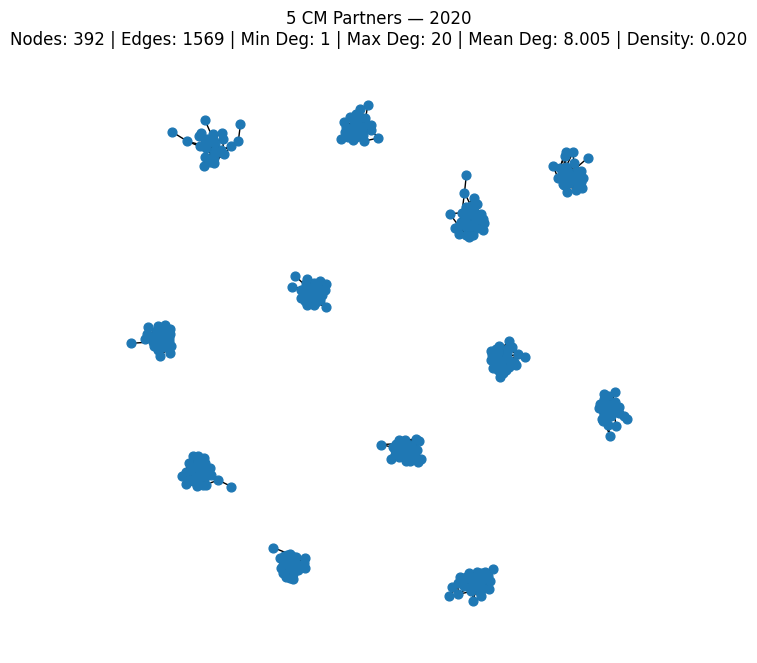

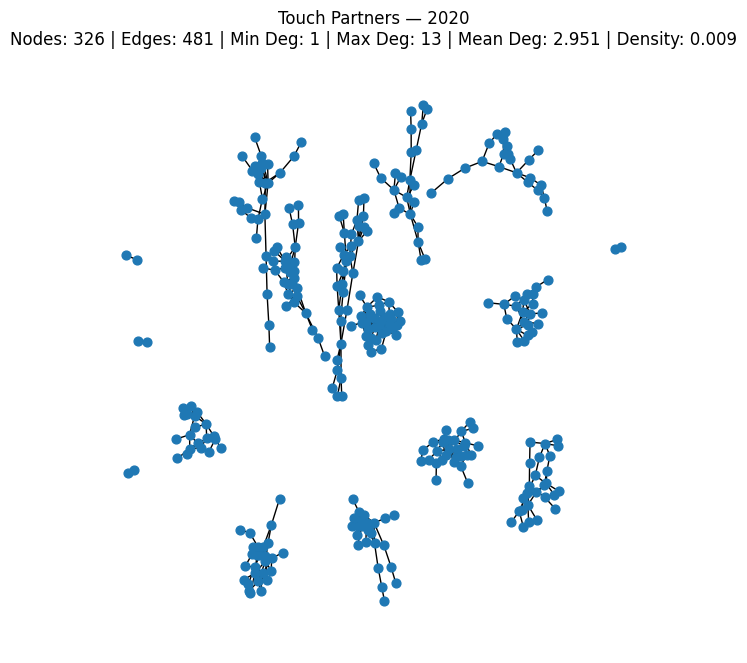

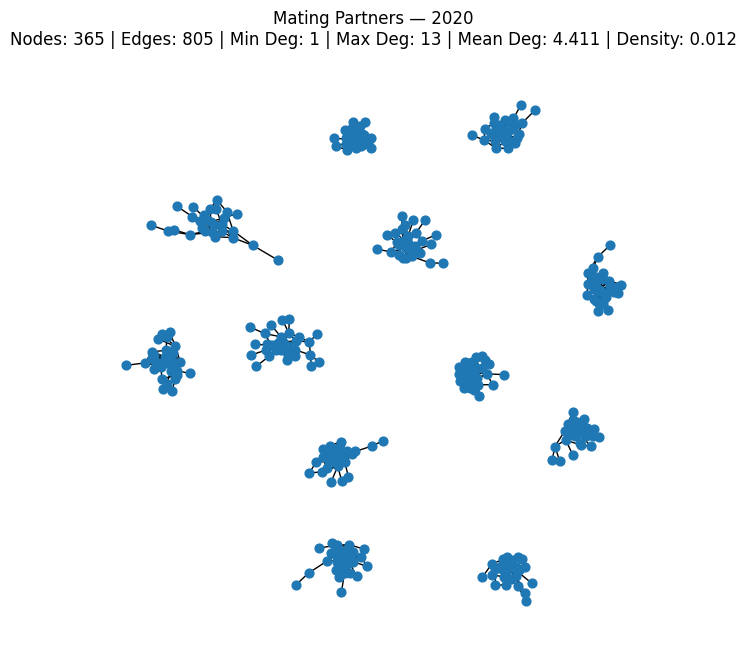

In [7]:
network_interactions('5 CM Partners')
network_interactions('Touch Partners')
network_interactions('Mating Partners')

This is cool and all, but it isn't very relevant to what the question is asking for. They want a table, then a strip plot.

In [ ]:
# Create a list to hold stats for each condo-network
all_stats = []

# Get unique network types and sorted condos from the 2020 data.
network_types = ['5 CM Partners', 'Touch Partners', 'Mating Partners']
condos = sorted(df['condo'].unique().to_list()) # I found `.unique()` in the documentation.

# Here we will loop through each network and then within each network we will loop through all the condos in that network.
for network in network_types:
    network_df = df_2020.filter(pl.col('partner_interaction') == network)
    for condo in condos:
        condo_df = network_df.filter(pl.col('condo') == condo)

        G = nx.Graph() # Empty Graph.
        G.add_nodes_from(pl.concat([condo_df['focal_id'], condo_df['partner_id']]).to_list()) # Adding nodes.
        G.add_edges_from(condo_df.select(["focal_id", "partner_id"]).rows()) # Adding edges.
        G.remove_nodes_from(list(nx.isolates(G))) # Removing isolates.

        # Relevant stats.
        n = G.number_of_nodes()
        m = G.number_of_edges()
        degrees = [d for _, d in G.degree()] # This was a cleaner way to get degrees.
        mean_deg = sum(degrees) / n
        min_deg = min(degrees)
        max_deg = max(degrees)
        density = (2 * m) / (n * (n - 1)) if n > 1 else 0.0

        all_stats.append({
            'Network': network,
            'Condo': condo,
            'Nodes': n,
            'Edges': m,
            'Min Degree': min_deg,
            'Max Degree': max_deg,
            'Mean Degree': mean_deg,
            'Density': density
        })

# Create a Polars DataFrame from the list of stats.
per_condo_stats_df = pl.DataFrame(all_stats)

In [23]:
# Calculate the average stats for the summary table. This formatting and `.select()` was found in the documentation.
avg_stats_df = per_condo_stats_df.group_by('Network').mean().select(
    pl.col('Network'),
    pl.col('Nodes').round(2),
    pl.col('Edges').round(2),
    pl.col('Min Degree').round(2),
    pl.col('Max Degree').round(2),
    pl.col('Mean Degree').round(3),
    pl.col('Density').round(4)
).sort('Network', descending=True)

avg_stats_df

Network,Nodes,Edges,Min Degree,Max Degree,Mean Degree,Density
str,f64,f64,f64,f64,f64,f64
"""Touch Partners""",27.17,40.08,1.0,7.92,2.905,0.1114
"""Mating Partners""",30.42,67.08,1.08,9.0,4.397,0.1495
"""5 CM Partners""",32.67,130.75,1.33,14.75,7.931,0.2492


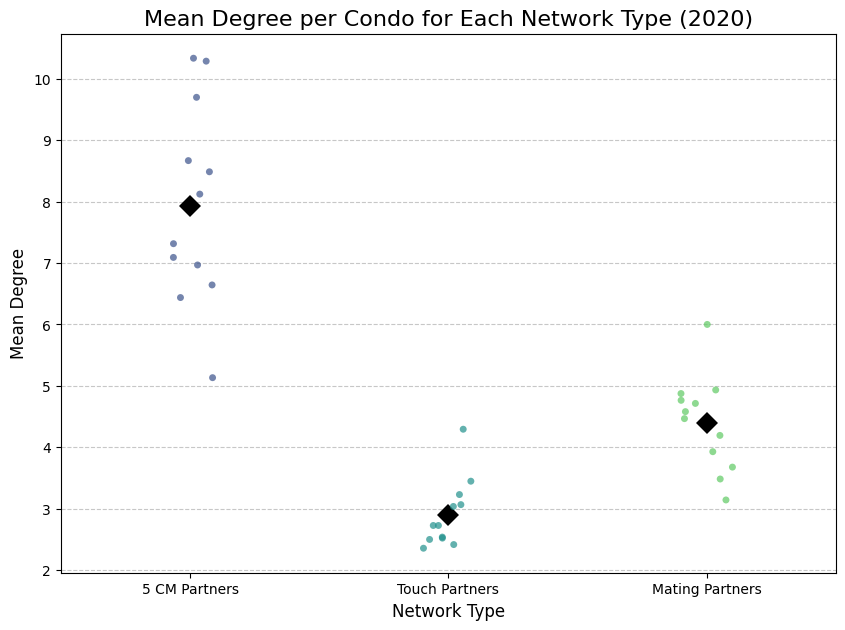

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 7)) # Matplotlib figure settings.

# Define a consistent order for plotting
network_order = ['5 CM Partners', 'Touch Partners', 'Mating Partners']

# Create the strip plot for individual condo data points
sns.stripplot(
    data=per_condo_stats_df.to_pandas(),
    x='Network',
    y='Mean Degree',
    jitter=True,
    alpha=0.7,
    order=network_order,
    palette='viridis'
)

# To achieve what the question is asking, we wwill need to overlay the point plot to show the average for each network
sns.pointplot(
    data=per_condo_stats_df.to_pandas(),
    x='Network',
    y='Mean Degree',
    markers='D',        # Diamond marker for the average (Seaborn Docs).
    color='black',
    join=False,         # Do not connect the points with a line (Seaborn Docs).
    ci=None,            # Do not show confidence interval bars (Seaborn Docs).
    scale=1.5,
    order=network_order
)

plt.title('Mean Degree per Condo for Each Network Type (2020)', fontsize=16)
plt.ylabel('Mean Degree', fontsize=12)
plt.xlabel('Network Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Prettying up.
plt.show()

### Mean Difference

The differences in the average mean degree across the three networks reflect the specificity and frequency of the underlying beetle behaviors.

**5 CM Partners**: This network has the highest mean degree $(7.931)$. This makes sense because proximity is the least specific interaction. Beetles are frequently within 5 cm of each other as they move around, feed, and rest, leading to many connections per beetle. It represents a general social environment rather than a specific interaction.

**Mating Partners**: This network has the intermediate mean degree $(4.397)$. Mating is a very specific and important social behavior. While more selective than just being nearby, a beetle might mate with several partners over time, creating a moderately connected network.

**Touch Partners**: This network has the lowest mean degree $(2.905)$. Touching is a more deliberate and intimate act than simple proximity but is likely less frequent or involves fewer partners than mating over the observation period. This results in the most sparsely connected network, where each beetle, on average, has the fewest direct connections.

In summary, the mean degree decreases as the social behavior becomes more selective and less frequent. Proximity is common, creating many edges, while touching is the most selective in this dataset, creating the fewest.

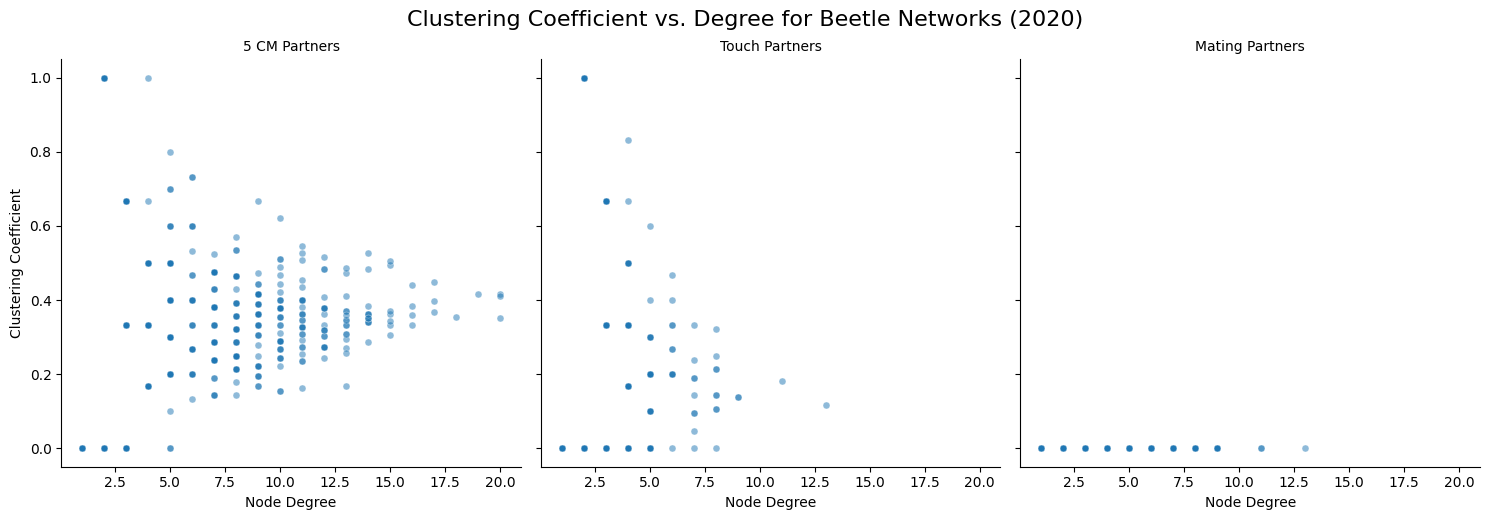

In [25]:
import pandas as pd # To mess with Seaborn it's easier to use Pandas over Polars. I also have more familiarity with Pandas.

node_data = [] # Empty now, will be populated.
network_types = ['5 CM Partners', 'Touch Partners', 'Mating Partners']

for network in network_types:
    # Filter for the specific network type, pooling all condos.
    network_df = df_2020.filter(pl.col('partner_interaction') == network)
    
    # Build the graph, just like before.
    G = nx.Graph()
    G.add_nodes_from(pl.concat([network_df['focal_id'], network_df['partner_id']]).to_list())
    G.add_edges_from(network_df.select(["focal_id","partner_id"]).rows())

    # Calculate degree and clustering for each node; similar to earlier labs.
    degrees = dict(G.degree())
    clustering_coeffs = nx.clustering(G)

    # Store the results
    for node in G.nodes():
        node_data.append({
            'Network': network,
            'Node': node,
            'Degree': degrees.get(node, 0),
            'Clustering': clustering_coeffs.get(node, 0)
        })

# Convert to a pandas DataFrame for plotting.
plot_df = pd.DataFrame(node_data)

# Create the scatter plots. Googled how to make prettier.
g = sns.relplot(
    data=plot_df,
    x='Degree',
    y='Clustering',
    col='Network',
    col_order=['5 CM Partners', 'Touch Partners', 'Mating Partners'],
    alpha=0.5,
    s=25,
    kind='scatter',
    palette='viridis'
)

# Set titles and labels. Googled to make prettier.
g.fig.suptitle('Clustering Coefficient vs. Degree for Beetle Networks (2020)', y=1.03, fontsize=16)
g.set_axis_labels("Node Degree", "Clustering Coefficient")
g.set_titles("{col_name}")

plt.show()

As you can see in the plots, the points generally trend downwards from left to right. Nodes with a low degree ($x$-axis) can have a wide range of clustering coefficients, but often have very high ones ($y$-axis). Conversely, nodes with a very high degree consistently have a clustering coefficient near zero.

### Explanation of the Negative Correlation
This negative correlation is a common feature of real-world social networks and suggests a hierarchical or community-based structure. Maybe this is why,
- **Low-Degree Nodes**: A beetle with only a few connections (a low degree) is likely part of a small, tight-knit social circle. Think of a beetle that primarily interacts with just two other beetles in its immediate vicinity. It is highly probable that those two neighbors also interact with each other because they are all part of the same local group. This makes up a closed triangle of connections (A-B, B-C, C-A), giving the beetle a high clustering coefficient.
- **High-Degree Nodes**: A beetle with many connections (a high degree) often acts as a bridge connecting several different, otherwise separate, social groups. For example, a "hub" beetle might interact with one group of beetles near a food source and a completely different group near a resting spot. Its neighbors are a mix of individuals from both groups. While the hub is connected to everyone, a beetle from the food group is unlikely to be connected to a beetle from the resting group. Because the hub's neighbors don't know each other, very few triangles are formed, resulting in a low clustering coefficient.

In essence, the network is not just all random; it's structured into many small, dense communities. The beetles that connect these different communities are the hubs, and this bridging role is what causes their clustering coefficient to be low despite having many connections.

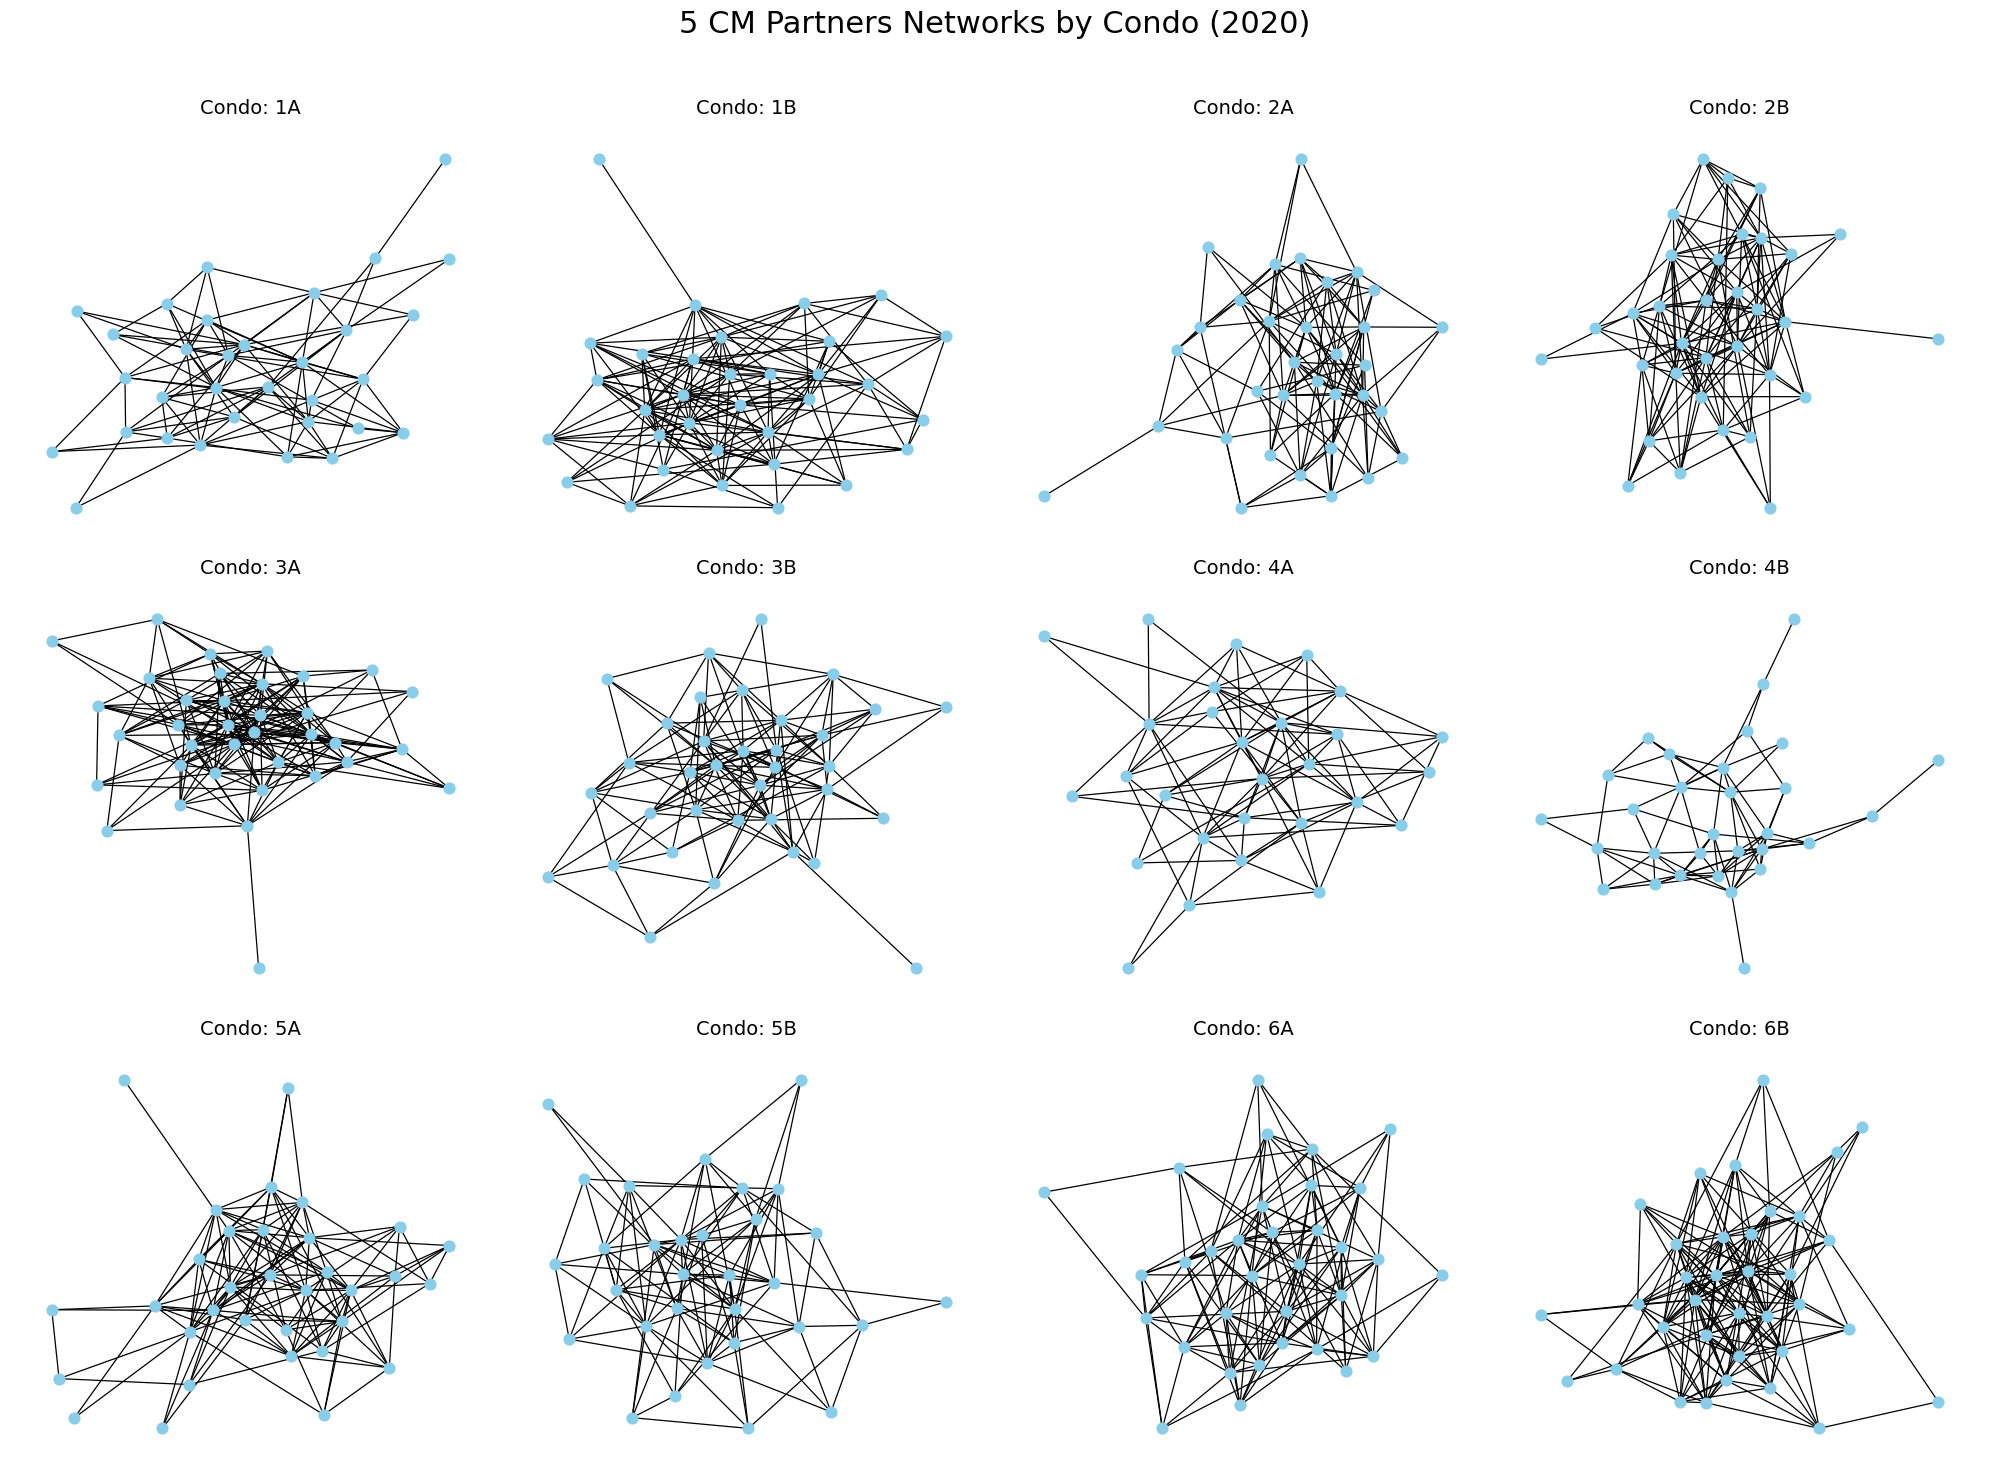

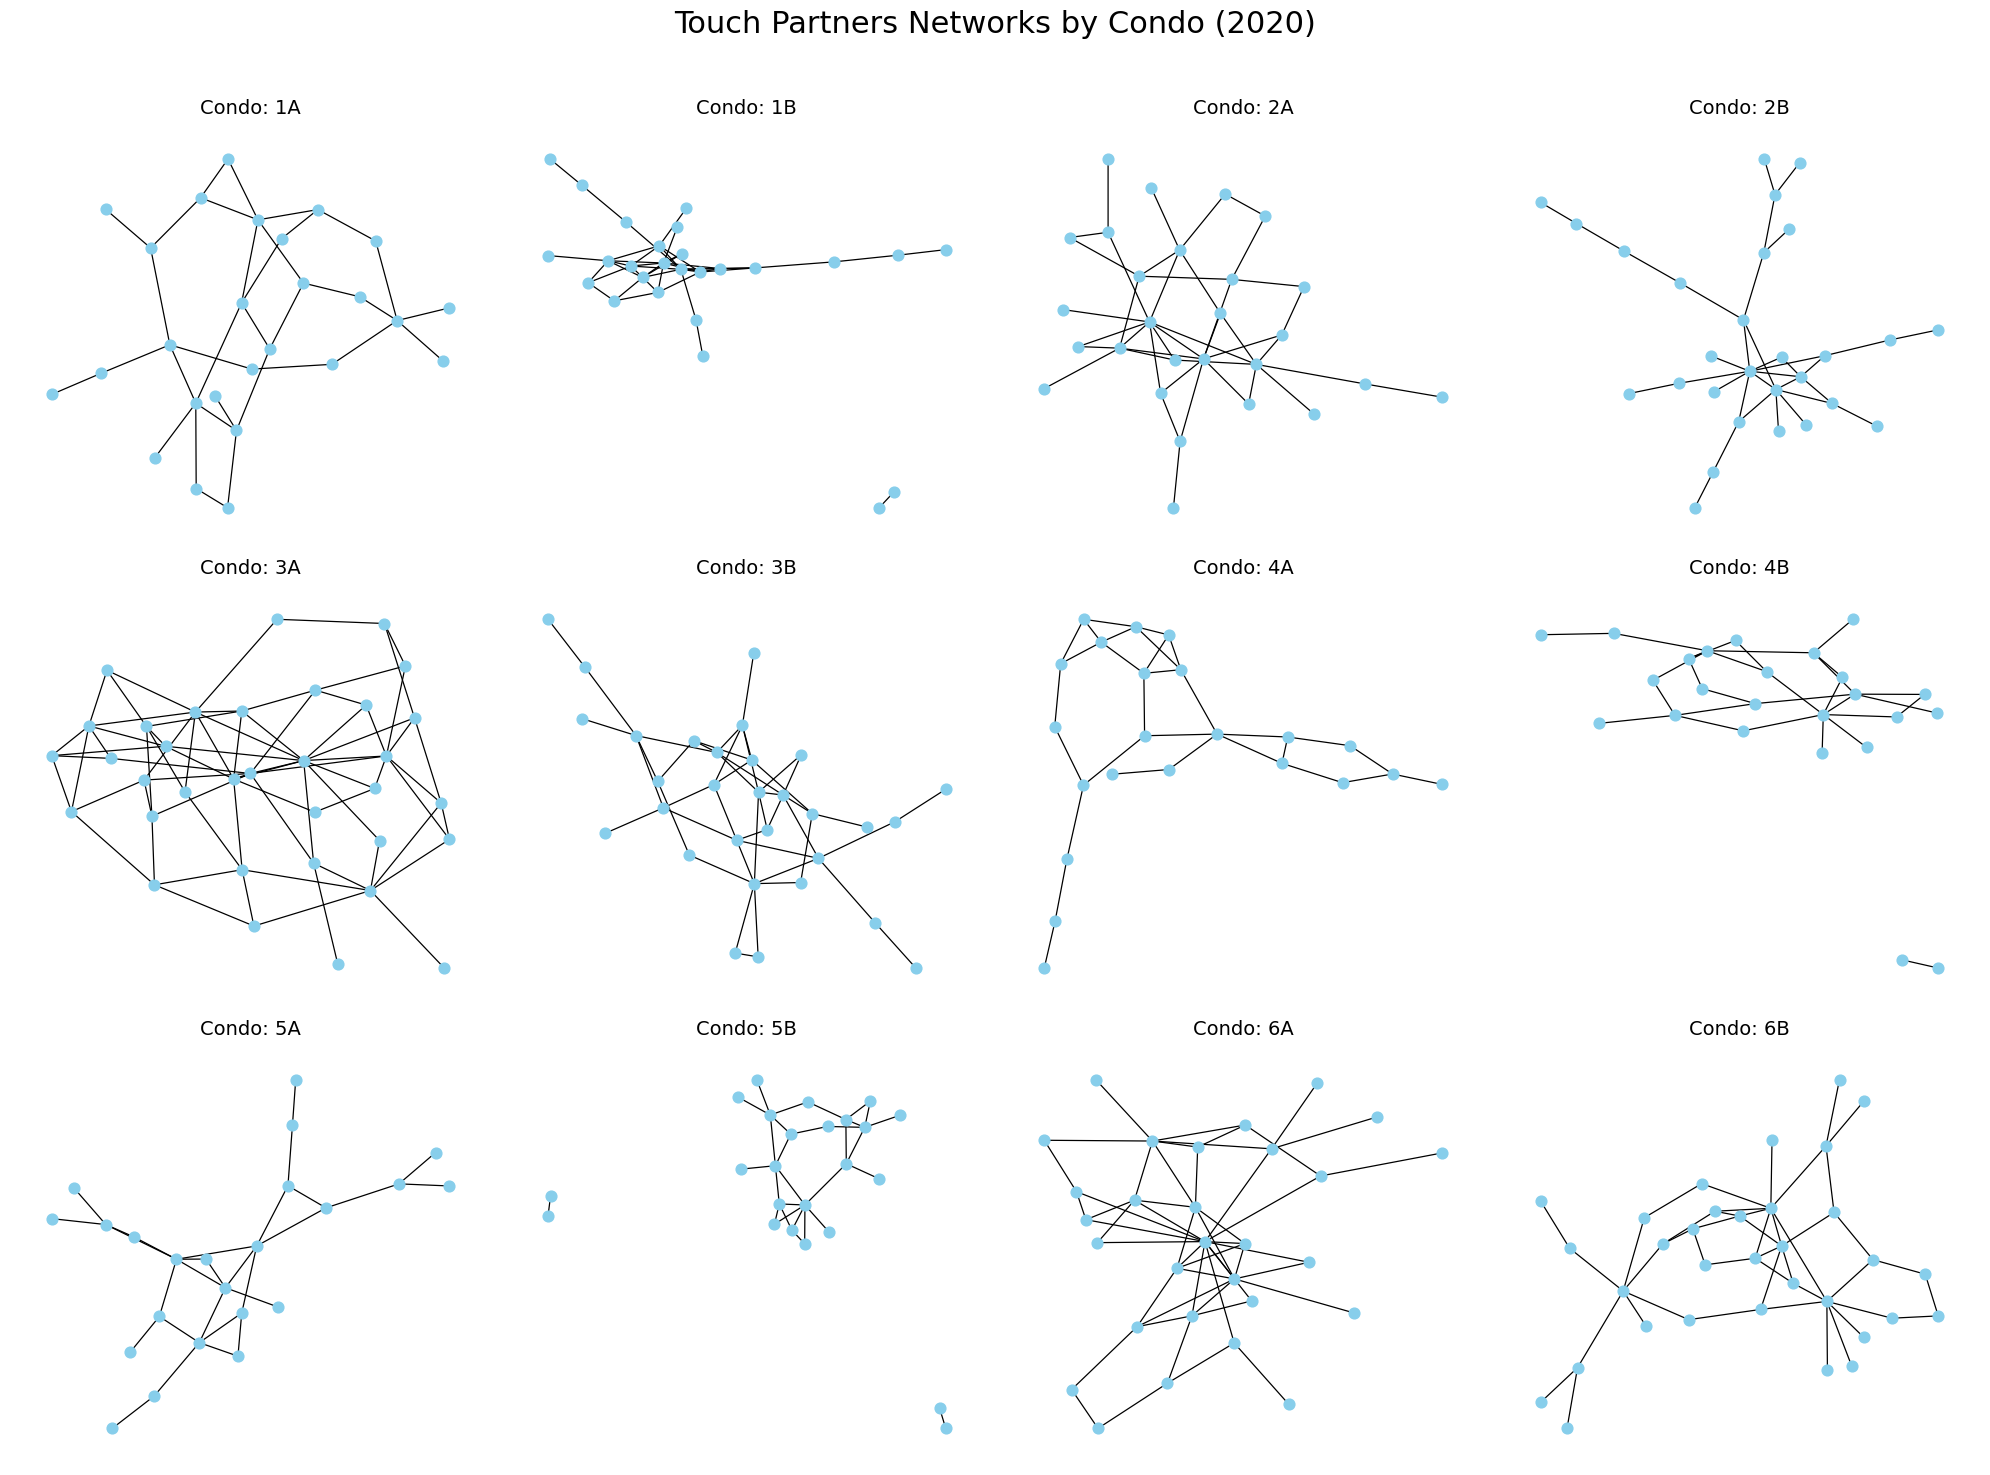

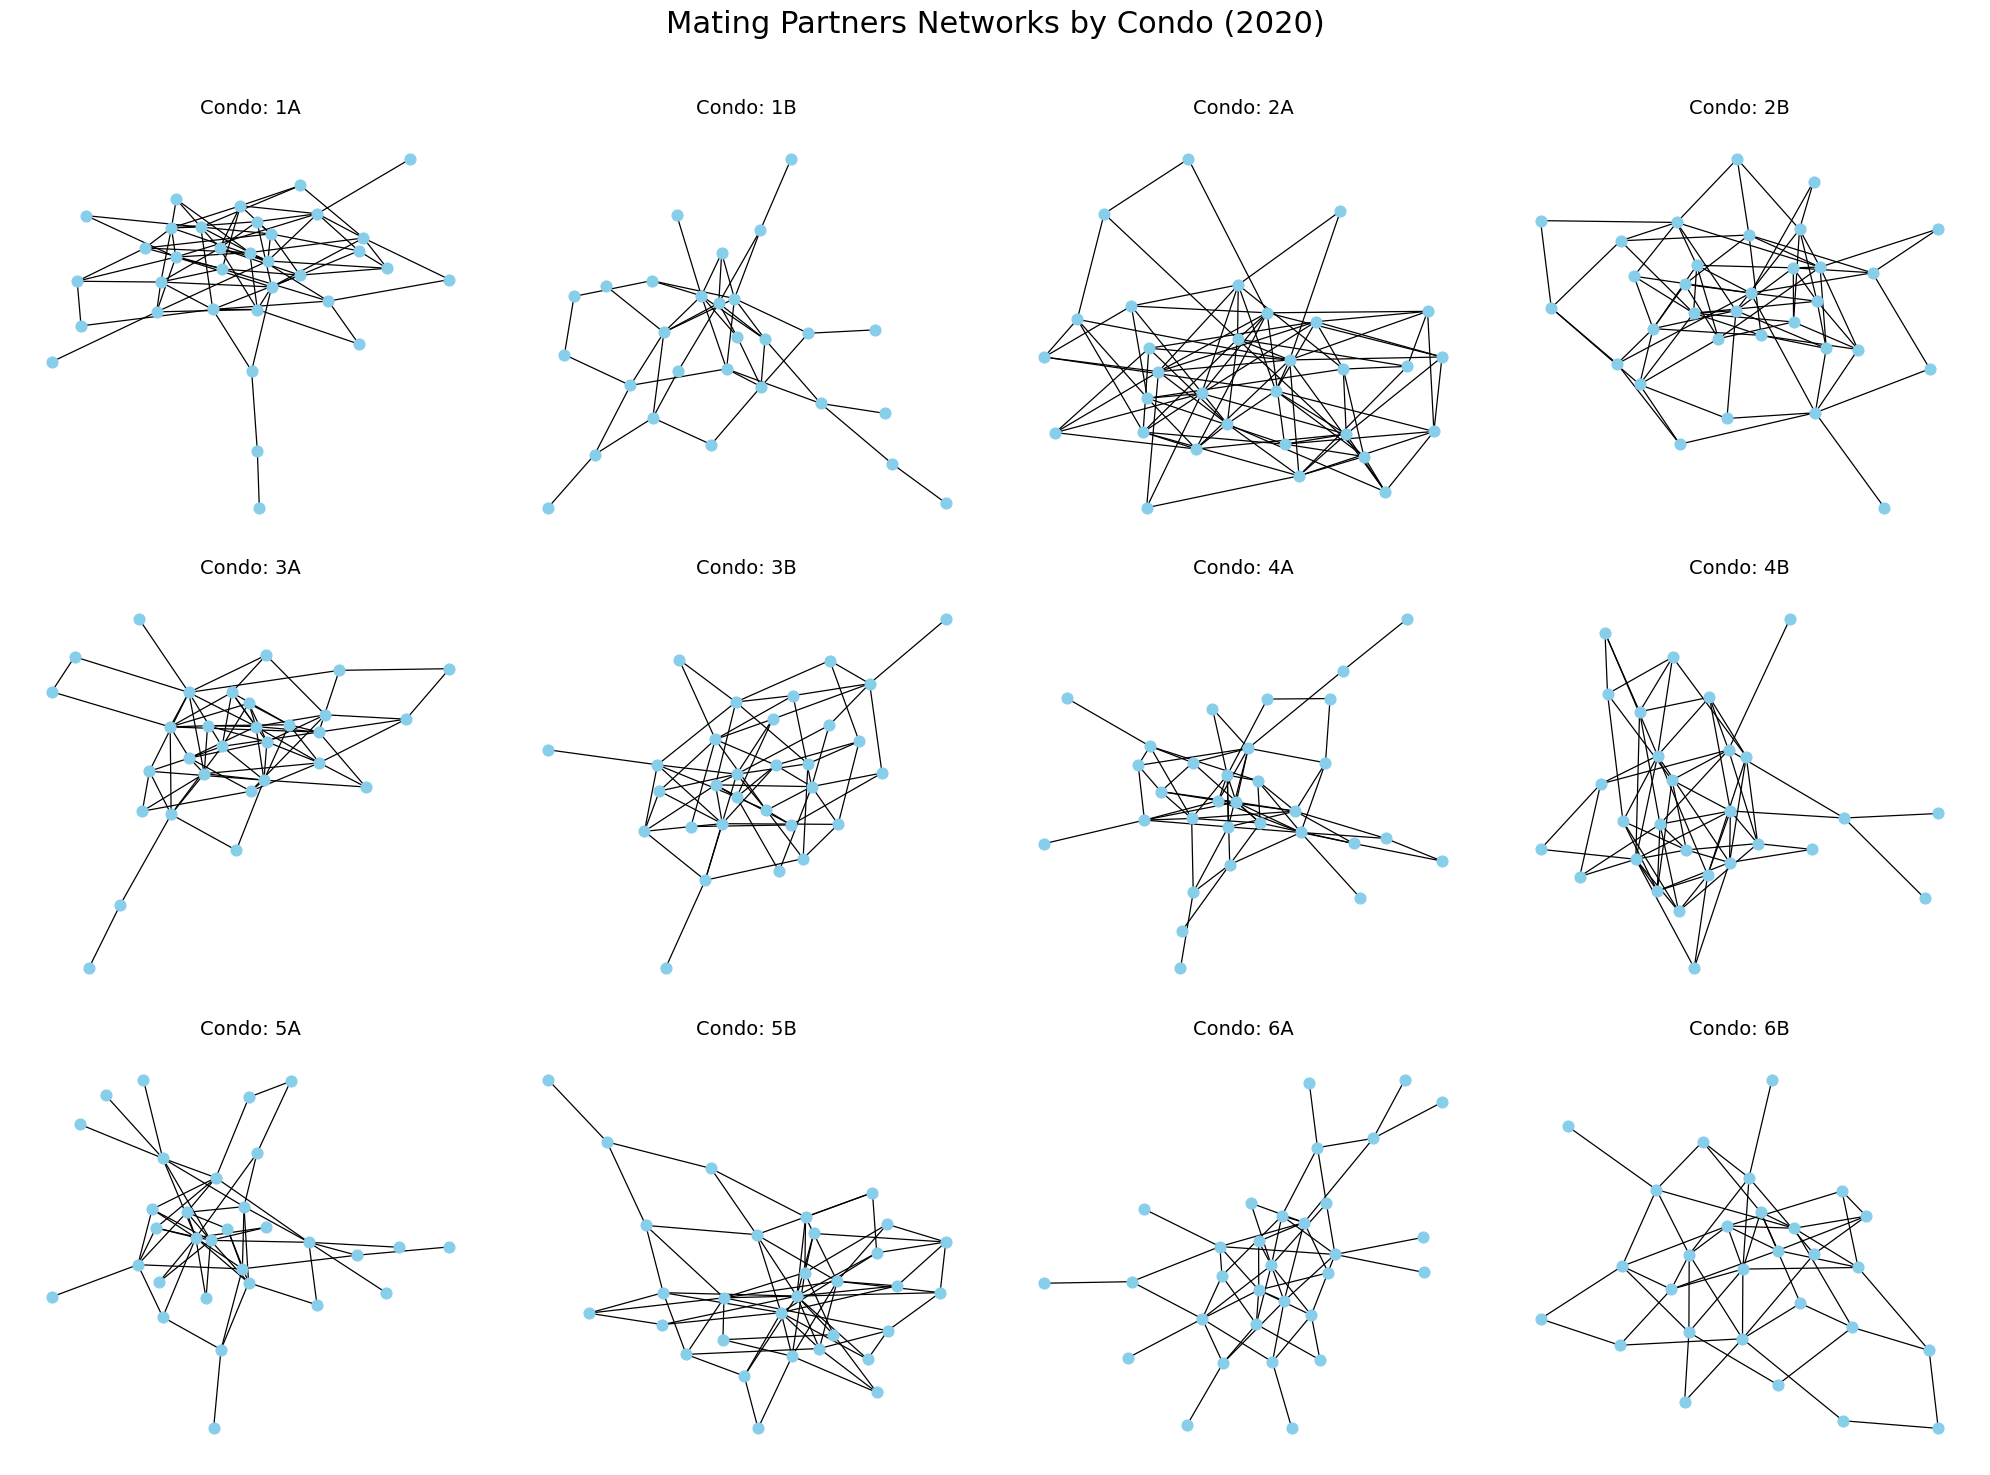

In [ ]:
# The sorted list of condos is already done from previous steps.
condo_list = sorted(df_2020['condo'].unique().to_list())
network_types = ['5 CM Partners', 'Touch Partners', 'Mating Partners']

# Loop for each of the three main network types to create a separate figure.
for network in network_types:
    
    # Create a 3x4 grid of subplots for the 12 condos.
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Add a main title.
    fig.suptitle(f'{network} Networks by Condo (2020)', fontsize=22)
    
    # Filter the data for the current network type
    network_df = df_2020.filter(pl.col('partner_interaction') == network)
    
    # Flatten the axes array for easy iteration and loop through the sorted condos; inspired from Googling.
    for ax, condo in zip(axes.flatten(), condo_list):
        
        # Filter for the specific condo.
        condo_df = network_df.filter(pl.col('condo') == condo)
        
        # Build the graph again.
        G = nx.Graph()
        G.add_nodes_from(pl.concat([condo_df['focal_id'], condo_df['partner_id']]).to_list())
        G.add_edges_from(condo_df.select(["focal_id","partner_id"]).rows())
        G.remove_nodes_from(list(nx.isolates(G)))
        
        # Drawing.
        pos = nx.spring_layout(G, seed=42) # Use a seed for reproducible layouts!!
        nx.draw(
            G, 
            pos, 
            ax=ax, 
            node_size=60, 
            width=0.9,
            with_labels=False,
            node_color='skyblue'
        )
        
        # Set the title for the subplot with the condo name, prettying up.
        ax.set_title(f"Condo: {condo}", fontsize=14)
        
    # Clean up layout to prevent titles from overlapping and display the figure
    plt.tight_layout(rect=[0, 0, 1, 0.96])

# HW01, Q03

Network 1 (Directed) Edge List: [(1, 2), (1, 5), (2, 3), (3, 4), (4, 5), (4, 1), (5, 1), (5, 2)]


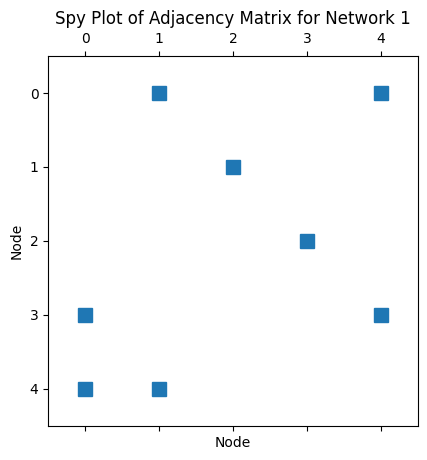

In [32]:
# Directed this time.
G1 = nx.DiGraph()
G1.add_edges_from([
    (1, 2), (2, 3), (3, 4), (4, 5), (5, 1),
    (1, 5), (5, 2), (4, 1)
])

print("Network 1 (Directed) Edge List:", G1.edges())

# Get and plot the adjacency matrix for Network 1
adj_matrix_1 = nx.adjacency_matrix(G1)
plt.spy(adj_matrix_1, markersize=10)
plt.title("Spy Plot of Adjacency Matrix for Network 1")
plt.xlabel("Node")
plt.ylabel("Node")
plt.show()


Network 2 (Bipartite) Edge List: [(1, 7), (1, 8), (2, 7), (2, 9), (3, 8), (3, 10), (4, 9), (4, 11), (5, 10), (5, 11), (6, 11)]


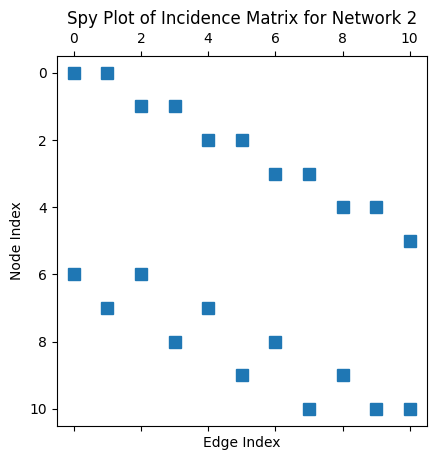

In [33]:
# Bipartite Network.
G2 = nx.Graph()

# Re-index nodes as per the hint: white nodes = 1-6, grey nodes = 7-11
white_nodes = [1, 2, 3, 4, 5, 6]
grey_nodes = [7, 8, 9, 10, 11] # Corresponds to original grey 1-5
G2.add_nodes_from(white_nodes, bipartite=0)
G2.add_nodes_from(grey_nodes, bipartite=1)

# Add edges based on the re-indexed nodes
G2.add_edges_from([
    (7, 1), (7, 2), (8, 1), (8, 3), (9, 2),
    (9, 4), (10, 3), (10, 5), (11, 4), (11, 5), (11, 6)
])

print("\nNetwork 2 (Bipartite) Edge List:", G2.edges())

# Get and plot the incidence matrix for Network 2.
# Rows are nodes, columns are edges.
inc_matrix_2 = nx.incidence_matrix(G2)
plt.spy(inc_matrix_2, markersize=8)
plt.title("Spy Plot of Incidence Matrix for Network 2")
plt.xlabel("Edge Index")
plt.ylabel("Node Index")
plt.show()

The answers to this part are so:

Network 1 (directed)
Edge List: $[(1, 2), (1, 5), (2, 3), (3, 4), (4, 5), (4, 1), (5, 1), (5, 2)]$

Network 2 (bipartite)
Edge List: $[(1, 7), (1, 8), (2, 7), (2, 9), (3, 8), (3, 10), (4, 9), (4, 11), (5, 10), (5, 11), (6, 11)]$

And the spy plots are given above.

### Part B

In any directed graph, the sum of all in-degrees equals the sum of all out-degrees, as each edge contributes to exactly one to both totals. 
$$ \sum_i k_{\text{in}}(i) = \sum_i k_{\text{out}}(i) = |E|. $$

Let the specific node in question be $j$. We are given:
$$ \sum_{i \neq j} k_{\text{in}}(i) - \sum_{i \neq j} k_{\text{out}} > 0 $$

We can rewrite the sums on the left as the total sum minus the contribution from node $j$:
$$ \left( \sum_i k_{\text{in}}(i) - k_{\text{in}}(j) \right) - \left( \sum_i k_{\text{out}}(i) - k_{\text{out}}(j) \right) > 0 $$

Since the total sums are equal:
$$
\begin{align*}
(|E| - k_{\text{in}}(j)) - (|E| - k_{\text{out}}(j)) &> 0 \\
-k_{\text{in}}(j) + k_{\text{out}}(j) &> 0 \\
k_{\text{out}}(j) &> k_{\text{in}}(j)
\end{align*}
$$

For the specific node $j$, it's out-degree has to be bigger than the in-degree. This node acts more as a "source" than a "sink" in the network. 

### Part C
Let the two sets of nodes be $U$ (grey nodes) and $V$ (white nodes). Let their sizes be $n_U$ and $n_V$, respectively.

Every edge in a bipartite network connects a node in $U$ to a node in $V$. Therefore, the sum of the degrees of all nodes in set $U$ is equal to the number of edges, $|E|$. The same is going to be true for the nodes in set $V$.
$$ \sum_{u \in U} k(u) = \sum_{v \in V}k(v) = |E| $$
The mean degree for the set of nodes is the sum of their degrees divided by number of nodes in that set:

$$ \langle k_U \rangle = \frac{\sum_{u \in U}k(u)}{n_U} \quad \text{ and } \quad \langle k_U \rangle = \frac{\sum_{v \in V}k(v)}{n_V} $$

By substituting $|E|$ into these equations, we get $\sum k(u) = n_U\langle k_U\rangle$ and $\sum k(v) = n_V \langle k_V \rangle$

Since both sums are equal to $|E|$, we can set them equals to each other: 
$$ n_U \langle k_U \rangle = n_V \langle k_V \rangle $$

To conclude, this expression relates the mean degrees of two node types. It shows that the totla number of edges originating from each partition is the same, and the mean degrees are inversely proportional to the sizes of the partitions.